In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression

from sklearn.decomposition import TruncatedSVD 

from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

from tensorflow.keras.optimizers import RMSprop

from tensorflow import convert_to_tensor, string

Matplotlib is building the font cache; this may take a moment.
/Users/akramar/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
messages_df = pd.read_json('messages/messages.jsonl', lines=True)

## Data Exploration

In [3]:
messages_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373311 entries, 0 to 373310
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   source_id     373311 non-null  int64         
 1   message_id    373311 non-null  int64         
 2   text          373311 non-null  object        
 3   impressions   373256 non-null  float64       
 4   reactions     373311 non-null  int64         
 5   shares        370136 non-null  float64       
 6   comments      373311 non-null  int64         
 7   published_at  373311 non-null  datetime64[ns]
 8   content_type  373311 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(4), object(2)
memory usage: 25.6+ MB


In [4]:
len(train_df), len(test_df), len(messages_df)

(3260, 1386, 373311)

In [5]:
train_df.head()

,source_id,source_url,source_category
0,133653,https://twitter.com/IFR2022,AGGRESSIVE_INFORMATION
1,39644,https://t.me/warfakeskrm,RESTRAINED_INFORMATION
2,245395,https://t.me/od_patrolpolice,SAFE_CONTENT
3,252210,https://t.me/trech_kich,SPAM
4,226108,https://t.me/sitreports,RESTRAINED_INFORMATION


In [6]:
messages_df.describe(include="all")

,source_id,message_id,text,impressions,reactions,shares,comments,published_at,content_type
count,3.733110e+05,3.733110e+05,373311,3.732560e+05,373311.000000,3.701360e+05,373311.000000,373311,373311
unique,NaN,NaN,338996,NaN,NaN,NaN,NaN,NaN,3
top,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,POST
freq,NaN,NaN,828,NaN,NaN,NaN,NaN,NaN,269719
mean,3.929642e+07,1.240145e+09,NaN,1.208559e+04,202.624763,2.564916e+02,7.516663,2024-03-04 11:42:52.119090944,NaN
min,2.000000e+00,1.459680e+05,NaN,0.000000e+00,0.000000,0.000000e+00,0.000000,2011-10-30 16:31:54,NaN
25%,2.285540e+05,1.250243e+09,NaN,1.800000e+01,0.000000,1.000000e+00,0.000000,2024-04-24 09:26:03,NaN
50%,2.046494e+06,1.396224e+09,NaN,6.920000e+02,7.000000,4.000000e+00,0.000000,2024-06-16 07:26:46,NaN
75%,8.666135e+07,1.418283e+09,NaN,4.887000e+03,66.000000,2.100000e+01,1.000000,2024-06-24 07:33:01,NaN
max,1.450078e+08,1.434559e+09,NaN,1.236680e+07,223784.000000,3.027542e+06,52455.000000,2024-06-27 03:36:01,NaN


In [7]:
duplicates_in_text = messages_df.duplicated(subset=['text'])
num_duplicates_text = duplicates_in_text.sum()
print(num_duplicates_text)

34315


In [8]:
print(messages_df.isnull().sum())

source_id          0
message_id         0
text               0
impressions       55
reactions          0
shares          3175
comments           0
published_at       0
content_type       0
dtype: int64


In [9]:
pd.options.display.float_format = '{:.2f}'.format
messages_df['shares'].describe()

count    370136.00
mean        256.49
std        6117.33
min           0.00
25%           1.00
50%           4.00
75%          21.00
max     3027542.00
Name: shares, dtype: float64

## Data Cleaning

In [10]:
messages_df['impressions'] = messages_df['impressions'].fillna(messages_df['impressions'].median())
messages_df['shares'] = messages_df['shares'].fillna(messages_df['shares'].median())

In [11]:
print(messages_df.isnull().sum())

source_id       0
message_id      0
text            0
impressions     0
reactions       0
shares          0
comments        0
published_at    0
content_type    0
dtype: int64


In [12]:
!pip install langdetect
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 7.8 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=d730425709a37f9c5b55332003b3f9c1ee03e44a50760edeebb1c8e59e8bcc2a
  Stored in directory: /Users/akramar/Library/Caches/pip/wheels/d1/c1/d9/7e068de779d863bc8f8fc9467d85e25cfe47fa5051fff1a1bb
Successfully built langdetect


In [13]:
!pip install spacy
!pip install stopwords-iso
!python -m spacy download ru_core_news_sm

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.4/109.4 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 10.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.0/182.0 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.0/409.0 kB 8.4 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 9.2 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.5/780.5 kB 9.0 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 5.9 MB/s eta 0:00:00
  

In [15]:
!pip install transformers

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 10.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 402.6/402.6 kB 8.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.3/278.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.3/411.3 kB 7.9 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 9.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 7.7 MB/s eta 0:00:00


In [17]:
def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown"

In [18]:
messages_df['language'] = messages_df['text'].apply(detect_language)

In [19]:
messages_df.describe(include="all")

,source_id,message_id,text,impressions,reactions,shares,comments,published_at,content_type,language
count,373311.00,373311.00,373311,373311.00,373311.00,373311.00,373311.00,373311,373311,373311
unique,NaN,NaN,338996,NaN,NaN,NaN,NaN,NaN,3,49
top,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,POST,ru
freq,NaN,NaN,828,NaN,NaN,NaN,NaN,NaN,269719,273518
mean,39296420.31,1240144894.23,NaN,12083.91,202.62,254.34,7.52,2024-03-04 11:42:52.119090944,NaN,NaN
min,2.00,145968.00,NaN,0.00,0.00,0.00,0.00,2011-10-30 16:31:54,NaN,NaN
25%,228554.00,1250242550.00,NaN,18.00,0.00,1.00,0.00,2024-04-24 09:26:03,NaN,NaN
50%,2046494.00,1396223942.00,NaN,692.00,7.00,4.00,0.00,2024-06-16 07:26:46,NaN,NaN
75%,86661347.00,1418283375.50,NaN,4886.00,66.00,21.00,1.00,2024-06-24 07:33:01,NaN,NaN
max,145007818.00,1434559415.00,NaN,12366797.00,223784.00,3027542.00,52455.00,2024-06-27 03:36:01,NaN,NaN


(-1.0999984367605113,
 1.0999967276050215,
 -1.099999953577478,
 1.0999999933275286)

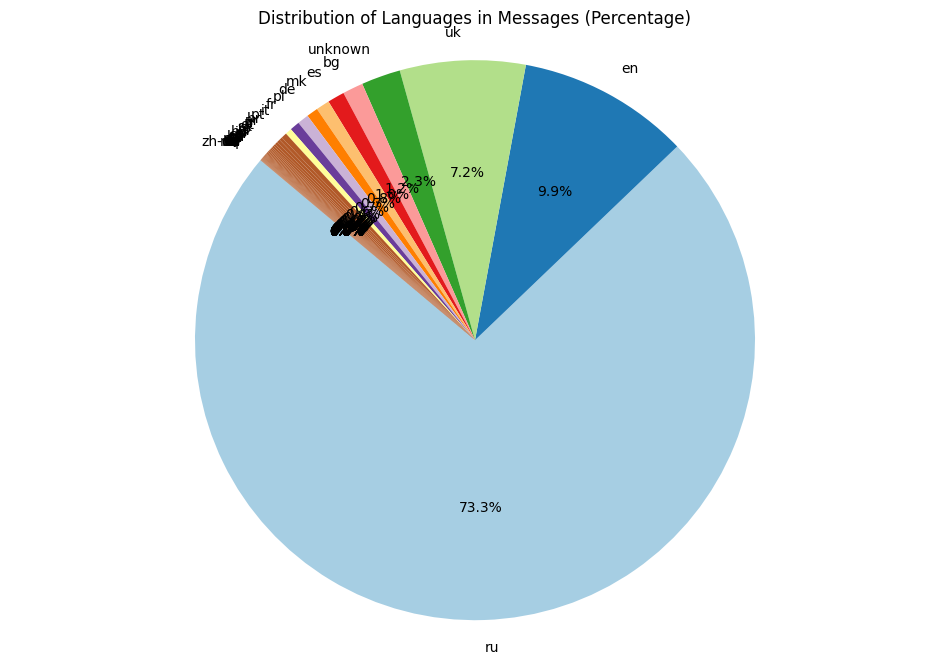

In [419]:
unique_languages = messages_df['language'].value_counts()

language_percentages = (unique_languages / unique_languages.sum()) * 100

plt.figure(figsize=(12, 8))
plt.pie(language_percentages, labels=language_percentages.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(language_percentages))))
plt.title('Distribution of Languages in Messages (Percentage)')
plt.axis('equal')

In [20]:
unique_languages = messages_df['language'].value_counts()
print(unique_languages)

unique_languages_list = messages_df['language'].unique()
print(unique_languages_list)

language
ru         273518
en          37075
uk          27044
unknown      8449
bg           4441
es           3658
mk           2911
de           2468
pl           2444
fr           2097
it           1395
pt           1197
hr            700
ar            672
tr            617
et            473
sk            434
ro            296
nl            295
ja            262
hu            255
id            249
el            238
sl            213
so            179
fi            165
ca            158
he            155
af            144
tl            143
sw            143
fa            115
cy            101
sv             97
no             96
da             95
ta             59
vi             51
lt             49
cs             41
sq             30
lv             25
ko             19
zh-cn          18
hi             17
mr              5
ne              2
ur              2
th              1
Name: count, dtype: int64
['unknown' 'ru' 'mk' 'bg' 'uk' 'en' 'tr' 'id' 'it' 'et' 'sw' 'so' 'de'
 'no' 'ta' '

In [21]:
mk_messages = messages_df[messages_df['language'] == 'unknown']
print(mk_messages[['text', 'language']])

                                                     text language
0       https://www.youtube.com/watch?v=eR9FIPXffUw&li...  unknown
5       https://www.youtube.com/watch?v=6QMu0mezmLE&li...  unknown
18      https://www.youtube.com/watch?v=10JRV85xgDk&li...  unknown
29            https://www.youtube.com/watch?v=7s_BUelsOqM  unknown
34            https://www.youtube.com/watch?v=m7d3lMIMz-k  unknown
...                                                   ...      ...
371960                            https://t.co/tm45az8J0C  unknown
371970                            https://t.co/1tWeEs620t  unknown
372009                            https://t.co/KamdM4hwgE  unknown
372011                            https://t.co/D7WeUush34  unknown
372030                            https://t.co/rX9DfLtCQH  unknown

[8449 rows x 2 columns]


In [22]:
messages_df['length'] = messages_df['text'].apply(len)

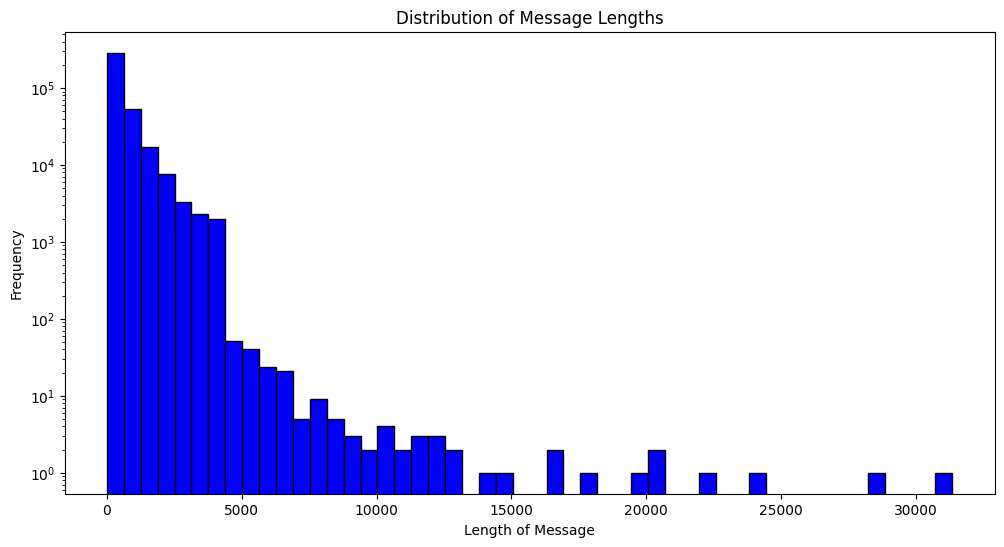

In [24]:
plt.figure(figsize=(12, 6))
plt.hist(messages_df['length'], bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Message Lengths')
plt.xlabel('Length of Message')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

In [26]:
lengths = messages_df['length']
percentiles = lengths.quantile([0.01, 0.99])

print(f"1st percentile (removal threshold): {percentiles[0.01]}")
print(f"99th percentile (truncation threshold): {percentiles[0.99]}")

1st percentile (removal threshold): 13.0
99th percentile (truncation threshold): 3327.0


In [35]:
!pip install spacy==3.5.1

import spacy.cli

spacy.cli.download("en_core_web_sm")
spacy.cli.download("ru_core_news_sm")
spacy.cli.download("uk_core_news_sm")

import spacy

nlp_en = spacy.load('en_core_web_sm')
nlp_ru = spacy.load('ru_core_news_sm')
nlp_uk = spacy.load('uk_core_news_sm')


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.6/151.6 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 2.9 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 10.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 790.7/790.7 kB 9.2 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: typer
    Found existing installation: typer 0.12.3
    Uninstalling typer-0.12.3:
      Successfully uninstalled typer-0.12.3
  Attempting uninstall: smart-open
    Found existing installation: smart-open 7.0.4
    Uninstalling smart-open-7.0.4:
      Successfully uninstalled smart-open-7.0.4
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.7.4
    Uninstalling pyda

## Data Preprocessing

In [36]:
DetectorFactory.seed = 0

In [39]:
!pip install stopwordsiso
import stopwordsiso as stopwords
stopwords_ru = stopwords.stopwords('ru')
stopwords_uk = stopwords.stopwords('uk')
stopwords_en = stopwords.stopwords('en')

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 3.0 MB/s eta 0:00:00


In [40]:
combined_stopwords = stopwords_ru | stopwords_uk | stopwords_en

In [41]:
!pip install pandas transformers stopwordsiso langdetect sentencepiece
import transformers
from transformers import XLMRobertaTokenizer
from langdetect import detect, DetectorFactory
import stopwordsiso as stopwords
tokenizer = transformers.AutoTokenizer.from_pretrained('jplu/tf-xlm-roberta-large')

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 8.4 MB/s eta 0:00:00a 0:00:01


config.json:   0%|          | 0.00/513 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

In [52]:
def preprocess_text(text, nlp, stop_words):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    doc = nlp(text)
    text = ' '.join([token.lemma_ for token in doc if token.text not in stop_words and not token.is_punct])
    
    return text

In [53]:
def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown"

In [54]:
def preprocess_based_on_language(row):
    text, language = row['text'], row['language']
    if language == 'ru':
        return preprocess_text(text, nlp_ru, stopwords_ru)
    elif language == 'uk':
        return preprocess_text(text, nlp_uk, stopwords_uk)
    elif language == 'en':
        return preprocess_text(text, nlp_en, stopwords_en)
    else:
        return preprocess_text(text, nlp_en, stopwords_en)

In [67]:
messages_df['cleaned_text'] = messages_df.apply(preprocess_based_on_language, axis=1)

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   source_id     10 non-null     int64         
 1   message_id    10 non-null     int64         
 2   text          10 non-null     object        
 3   impressions   10 non-null     float64       
 4   reactions     10 non-null     int64         
 5   shares        10 non-null     float64       
 6   comments      10 non-null     int64         
 7   published_at  10 non-null     datetime64[ns]
 8   content_type  10 non-null     object        
 9   language      10 non-null     object        
 10  length        10 non-null     int64         
 11  cleaned_text  10 non-null     object        
dtypes: datetime64[ns](1), float64(2), int64(5), object(4)
memory usage: 1.1+ KB


In [191]:
aggregated_messages = messages_df.groupby('source_id').agg({
    'cleaned_text': lambda x: ' '.join(x),
    'impressions': 'mean',
    'reactions': 'sum',
    'shares': 'sum',
    'comments': 'sum',
    'published_at': ['min', 'max'],
    'content_type': lambda x: x.mode()[0],
    'language': lambda x: x.mode()[0]
}).reset_index()

In [192]:
aggregated_messages.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in aggregated_messages.columns]

In [193]:
aggregated_messages.rename(columns={
    'source_id_': 'source_id',
    'cleaned_text_<lambda>': 'text',
    'impressions_mean': 'average_impressions',
    'reactions_sum': 'total_reactions',
    'shares_sum': 'total_shares',
    'comments_sum': 'total_comments',
    'published_at_min': 'first_post_date',
    'published_at_max': 'last_post_date',
    'content_type_<lambda>': 'most_common_content_type',
    'language_<lambda>': 'most_common_language'
}, inplace=True)

In [194]:
aggregated_messages['engagement_rate'] = aggregated_messages.apply(
    lambda row: (row['total_reactions'] + row['total_shares'] + row['total_comments']) / row['average_impressions']
    if row['average_impressions'] > 0 else 0, axis=1)

In [195]:
aggregated_messages['post_frequency'] = aggregated_messages.apply(
    lambda row: (row['last_post_date'] - row['first_post_date']).days / len(messages_df['source_id'].unique()), axis=1)

In [196]:
numerical_features = ['average_impressions', 'total_reactions', 'total_shares', 'total_comments', 'engagement_rate', 'post_frequency']
aggregated_messages[numerical_features] = aggregated_messages[numerical_features].replace([np.inf, -np.inf], np.nan)
aggregated_messages[numerical_features] = aggregated_messages[numerical_features].fillna(0)

In [197]:
aggregated_messages.describe(include="all")

,source_id,text,average_impressions,total_reactions,total_shares,total_comments,first_post_date,last_post_date,most_common_content_type,most_common_language,engagement_rate,post_frequency
count,4660.00,4660,4660.00,4660.00,4660.00,4660.00,4660,4660,4660,4660,4660.00,4660.00
unique,NaN,4650,NaN,NaN,NaN,NaN,NaN,NaN,3,29,NaN,NaN
top,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,POST,ru,NaN,NaN
freq,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,3669,3481,NaN,NaN
mean,48853041.71,NaN,12273.54,16232.20,20375.43,602.16,2023-11-04 13:17:00.293991168,2024-03-21 17:23:49.422103040,NaN,NaN,20261.58,0.03
min,2.00,NaN,0.00,0.00,0.00,0.00,2011-10-30 16:31:54,2015-09-20 13:09:54,NaN,NaN,0.00,0.00
25%,233568.25,NaN,32.31,18.00,164.75,0.00,2023-09-08 19:16:50.249999872,2024-06-16 18:54:41,NaN,NaN,0.24,0.00
50%,6418790.00,NaN,869.75,911.00,792.00,12.00,2024-05-20 09:10:14,2024-06-26 08:41:31,NaN,NaN,1.62,0.00
75%,95564706.50,NaN,5286.46,6476.50,4924.00,174.00,2024-06-18 23:58:05.500000,2024-06-26 16:08:08.249999872,NaN,NaN,5.32,0.02
max,145007818.00,NaN,6183812.00,1771688.00,5826183.00,310514.00,2024-06-26 20:44:59,2024-06-27 03:36:01,NaN,NaN,14400000.00,0.70


In [198]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
aggregated_messages[numerical_features] = scaler.fit_transform(aggregated_messages[numerical_features])

In [199]:
aggregated_messages.describe(include="all")

,source_id,text,average_impressions,total_reactions,total_shares,total_comments,first_post_date,last_post_date,most_common_content_type,most_common_language,engagement_rate,post_frequency
count,4660.00,4660,4660.00,4660.00,4660.00,4660.00,4660,4660,4660,4660,4660.00,4660.00
unique,NaN,4650,NaN,NaN,NaN,NaN,NaN,NaN,3,29,NaN,NaN
top,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,POST,ru,NaN,NaN
freq,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,3669,3481,NaN,NaN
mean,48853041.71,NaN,-0.00,0.00,0.00,0.00,2023-11-04 13:17:00.293991168,2024-03-21 17:23:49.422103040,NaN,NaN,-0.00,0.00
min,2.00,NaN,-0.12,-0.22,-0.16,-0.09,2011-10-30 16:31:54,2015-09-20 13:09:54,NaN,NaN,-0.05,-0.44
25%,233568.25,NaN,-0.12,-0.22,-0.16,-0.09,2023-09-08 19:16:50.249999872,2024-06-16 18:54:41,NaN,NaN,-0.05,-0.42
50%,6418790.00,NaN,-0.11,-0.20,-0.16,-0.09,2024-05-20 09:10:14,2024-06-26 08:41:31,NaN,NaN,-0.05,-0.37
75%,95564706.50,NaN,-0.07,-0.13,-0.12,-0.06,2024-06-18 23:58:05.500000,2024-06-26 16:08:08.249999872,NaN,NaN,-0.05,-0.13
max,145007818.00,NaN,59.25,23.35,46.36,46.48,2024-06-26 20:44:59,2024-06-27 03:36:01,NaN,NaN,36.73,9.95


In [202]:
aggregated_messages['post_duration'] = (aggregated_messages['last_post_date'] - aggregated_messages['first_post_date']).dt.days
aggregated_messages = aggregated_messages.drop(columns=['first_post_date', 'last_post_date'])

In [203]:
aggregated_messages.describe(include="all")

,source_id,text,average_impressions,total_reactions,total_shares,total_comments,most_common_content_type,most_common_language,engagement_rate,post_frequency,post_duration
count,4660.00,4660,4660.00,4660.00,4660.00,4660.00,4660,4660,4660.00,4660.00,4660.00
unique,NaN,4650,NaN,NaN,NaN,NaN,3,29,NaN,NaN,NaN
top,NaN,,NaN,NaN,NaN,NaN,POST,ru,NaN,NaN,NaN
freq,NaN,5,NaN,NaN,NaN,NaN,3669,3481,NaN,NaN,NaN
mean,48853041.71,NaN,-0.00,0.00,0.00,0.00,NaN,NaN,-0.00,0.00,137.74
std,56478401.71,NaN,1.00,1.00,1.00,1.00,NaN,NaN,1.00,1.00,314.14
min,2.00,NaN,-0.12,-0.22,-0.16,-0.09,NaN,NaN,-0.05,-0.44,0.00
25%,233568.25,NaN,-0.12,-0.22,-0.16,-0.09,NaN,NaN,-0.05,-0.42,5.00
50%,6418790.00,NaN,-0.11,-0.20,-0.16,-0.09,NaN,NaN,-0.05,-0.37,21.00
75%,95564706.50,NaN,-0.07,-0.13,-0.12,-0.06,NaN,NaN,-0.05,-0.13,97.00


In [205]:
le_content_type = LabelEncoder()
le_language = LabelEncoder()
aggregated_messages['encoded_content_type'] = le_content_type.fit_transform(aggregated_messages['most_common_content_type'])
aggregated_messages['encoded_language'] = le_language.fit_transform(aggregated_messages['most_common_language'])

In [206]:
aggregated_messages.describe(include="all")

,source_id,text,average_impressions,total_reactions,total_shares,total_comments,most_common_content_type,most_common_language,engagement_rate,post_frequency,post_duration,encoded_content_type,encoded_language
count,4660.00,4660,4660.00,4660.00,4660.00,4660.00,4660,4660,4660.00,4660.00,4660.00,4660.00,4660.00
unique,NaN,4650,NaN,NaN,NaN,NaN,3,29,NaN,NaN,NaN,NaN,NaN
top,NaN,,NaN,NaN,NaN,NaN,POST,ru,NaN,NaN,NaN,NaN,NaN
freq,NaN,5,NaN,NaN,NaN,NaN,3669,3481,NaN,NaN,NaN,NaN,NaN
mean,48853041.71,NaN,-0.00,0.00,0.00,0.00,NaN,NaN,-0.00,0.00,137.74,1.21,19.85
std,56478401.71,NaN,1.00,1.00,1.00,1.00,NaN,NaN,1.00,1.00,314.14,0.41,6.33
min,2.00,NaN,-0.12,-0.22,-0.16,-0.09,NaN,NaN,-0.05,-0.44,0.00,0.00,0.00
25%,233568.25,NaN,-0.12,-0.22,-0.16,-0.09,NaN,NaN,-0.05,-0.42,5.00,1.00,22.00
50%,6418790.00,NaN,-0.11,-0.20,-0.16,-0.09,NaN,NaN,-0.05,-0.37,21.00,1.00,22.00
75%,95564706.50,NaN,-0.07,-0.13,-0.12,-0.06,NaN,NaN,-0.05,-0.13,97.00,1.00,22.00


In [207]:
aggregated_messages = aggregated_messages.drop(columns=['most_common_content_type', 'most_common_language'])

## Model Selection

In [211]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

In [212]:
def tokenize_text(text):
    return tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors='tf')

In [226]:
aggregated_messages['tokenized'] = aggregated_messages['text'].apply(tokenize_text)

In [227]:
aggregated_messages.describe(include="all")

,source_id,text,average_impressions,total_reactions,total_shares,total_comments,engagement_rate,post_frequency,post_duration,encoded_content_type,encoded_language,tokenized
count,4660.00,4660,4660.00,4660.00,4660.00,4660.00,4660.00,4660.00,4660.00,4660.00,4660.00,4660
unique,NaN,4650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4660
top,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[input_ids, token_type_ids, attention_mask]"
freq,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
mean,48853041.71,NaN,-0.00,0.00,0.00,0.00,-0.00,0.00,137.74,1.21,19.85,NaN
std,56478401.71,NaN,1.00,1.00,1.00,1.00,1.00,1.00,314.14,0.41,6.33,NaN
min,2.00,NaN,-0.12,-0.22,-0.16,-0.09,-0.05,-0.44,0.00,0.00,0.00,NaN
25%,233568.25,NaN,-0.12,-0.22,-0.16,-0.09,-0.05,-0.42,5.00,1.00,22.00,NaN
50%,6418790.00,NaN,-0.11,-0.20,-0.16,-0.09,-0.05,-0.37,21.00,1.00,22.00,NaN
75%,95564706.50,NaN,-0.07,-0.13,-0.12,-0.06,-0.05,-0.13,97.00,1.00,22.00,NaN


In [229]:
aggregated_messages['input_ids'] = aggregated_messages['tokenized'].apply(lambda x: x['input_ids'][0])

In [230]:
aggregated_messages['attention_mask'] = aggregated_messages['tokenized'].apply(lambda x: x['attention_mask'][0])
aggregated_messages['token_type_ids'] = aggregated_messages['tokenized'].apply(lambda x: x['token_type_ids'][0])

In [232]:
aggregated_messages = aggregated_messages.drop(columns=['tokenized'])

In [427]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [428]:
train_merged = pd.merge(train_df, aggregated_messages, on='source_id', how='left')
test_merged = pd.merge(test_df, aggregated_messages, on='source_id', how='left')

In [434]:
numerical_features = ['average_impressions', 'total_reactions', 'total_shares', 'total_comments', 'engagement_rate', 'post_frequency', 'post_duration', 'encoded_content_type', 'encoded_language']

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_merged['source_category'] = label_encoder.fit_transform(train_merged['source_category'])

def convert_to_tensor(column):
    return tf.convert_to_tensor(np.stack(column.values))

train_merged['input_ids'] = convert_to_tensor(train_merged['input_ids'])
train_merged['attention_mask'] = convert_to_tensor(train_merged['attention_mask'])
train_merged['token_type_ids'] = convert_to_tensor(train_merged['token_type_ids'])

test_merged['input_ids'] = convert_to_tensor(test_merged['input_ids'])
test_merged['attention_mask'] = convert_to_tensor(test_merged['attention_mask'])
test_merged['token_type_ids'] = convert_to_tensor(test_merged['token_type_ids'])

In [435]:
from sklearn.model_selection import train_test_split

X_train_text, X_val_text, X_train_num, X_val_num, y_train, y_val = train_test_split(
    list(zip(train_merged['input_ids'], train_merged['attention_mask'], train_merged['token_type_ids'])),
    train_merged[numerical_features].values,
    train_merged['source_category'].values,
    test_size=0.2, random_state=42, stratify=train_merged['source_category']
)

X_train_input_ids, X_train_attention_mask, X_train_token_type_ids = zip(*X_train_text)
X_val_input_ids, X_val_attention_mask, X_val_token_type_ids = zip(*X_val_text)

train_inputs = {
    'input_ids': tf.convert_to_tensor(X_train_input_ids, dtype=tf.int32),
    'attention_mask': tf.convert_to_tensor(X_train_attention_mask, dtype=tf.int32),
    'token_type_ids': tf.convert_to_tensor(X_train_token_type_ids, dtype=tf.int32),
    'numerical_features': tf.convert_to_tensor(X_train_num, dtype=tf.float32)
}

val_inputs = {
    'input_ids': tf.convert_to_tensor(X_val_input_ids, dtype=tf.int32),
    'attention_mask': tf.convert_to_tensor(X_val_attention_mask, dtype=tf.int32),
    'token_type_ids': tf.convert_to_tensor(X_val_token_type_ids, dtype=tf.int32),
    'numerical_features': tf.convert_to_tensor(X_val_num, dtype=tf.float32)
}

train_labels = tf.convert_to_tensor(y_train, dtype=tf.int32)
val_labels = tf.convert_to_tensor(y_val, dtype=tf.int32)

In [85]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
bert_model = TFBertModel.from_pretrained('bert-base-multilingual-cased')

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [437]:
from transformers import TFBertModel
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, concatenate, Dropout
from tensorflow.keras.models import Model

class BertLayer(tf.keras.layers.Layer):
    def __init__(self, bert_model):
        super(BertLayer, self).__init__()
        self.bert = bert_model

    def call(self, inputs):
        input_ids, attention_mask, token_type_ids = inputs
        return self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)[0]

bert_model = TFBertModel.from_pretrained('bert-base-multilingual-cased')

input_ids = Input(shape=(128,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(128,), dtype=tf.int32, name='attention_mask')
token_type_ids = Input(shape=(128,), dtype=tf.int32, name='token_type_ids')

bert_output = BertLayer(bert_model)([input_ids, attention_mask, token_type_ids])
cls_token = bert_output[:, 0, :]

numerical_features_input = Input(shape=(len(numerical_features),), dtype=tf.float32, name='numerical_features')
dense_numerical = Dense(64, activation='relu')(numerical_features_input)

combined = concatenate([cls_token, dense_numerical])
combined = Dropout(0.3)(combined)
combined = Dense(128, activation='relu')(combined)
combined = Dropout(0.3)(combined)

output = Dense(len(label_encoder.classes_), activation='softmax')(combined)

model = Model(inputs=[input_ids, attention_mask, token_type_ids, numerical_features_input], outputs=output)

optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [408]:
history = bert_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    steps_per_epoch=100,
    validation_steps=50
)

Epoch 1/5
100/100 [==============================] - 466s 5s/step - loss: 1.6120 - accuracy: 0.4205 - val_loss: 1.4490 - val_accuracy: 0.4641
Epoch 2/5
100/100 [==============================] - 446s 4s/step - loss: 1.4764 - accuracy: 0.4356 - val_loss: 1.4413 - val_accuracy: 0.3538
Epoch 3/5
100/100 [==============================] - 448s 4s/step - loss: 1.4719 - accuracy: 0.4359 - val_loss: 1.4592 - val_accuracy: 0.4635
Epoch 4/5
100/100 [==============================] - 451s 5s/step - loss: 1.4927 - accuracy: 0.4347 - val_loss: 1.4924 - val_accuracy: 0.3519
Epoch 5/5
100/100 [==============================] - 448s 4s/step - loss: 1.4850 - accuracy: 0.4283 - val_loss: 1.4611 - val_accuracy: 0.4673


In [248]:
print(train_df['input_ids'].iloc[0])
print(train_df['attention_mask'].iloc[0])
print(train_df['token_type_ids'].iloc[0])

tf.Tensor(
[   101  31515  13129  64794  24173  64794  18073  11630  12047  13735
  49462  51504  12436  18586  10741  21671  13484  11478  25432  28101
  10472  16586  16586  64794  24173  11519  85353  11859  10147  19867
  12779 105133  13420  20124  41924  13723  11857  26219  50079  10567
  49148  11131  64794  24173  15217  13021  24620  13295  14985  32340
  79203  11131  64794  24173  64794  18073  11630  11426  34394  28101
  14446  42527  14590  40017    102      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0], shape=(128,), dtype=int32)
tf.Tensor(
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [296]:
test_inputs = {
    'input_ids': tf.convert_to_tensor(input_ids_test),
    'attention_mask': tf.convert_to_tensor(attention_mask_test),
    'token_type_ids': tf.convert_to_tensor(token_type_ids_test)
}

In [297]:
test_predictions = model.predict(test_inputs)

44/44 [==============================] - 58s 1s/step


In [298]:
test_predictions_labels = np.argmax(test_predictions.logits, axis=1)

In [299]:
test_df['predicted_category'] = label_encoder.inverse_transform(test_predictions_labels)

In [300]:
submission_df = pd.DataFrame({
    'source_id': test_df['source_id'],
    'predicted_category': test_df['predicted_category']
})

In [301]:
submission_df.to_csv('submission2.csv', index=False)

In [114]:
class_distribution = train_df['source_category'].value_counts()
print("Class distribution in training data:")
print(class_distribution)

Class distribution in training data:
source_category
AGGRESSIVE_INFORMATION                  1499
RESTRAINED_INFORMATION                  1174
AGGRESSIVE_MILITARY                      108
RESTRAINED_MILITARY                      107
SAFE_CONTENT                              91
ENTITIES_PROMOTING_VIOLENCE_AND_HATE      83
UNRECOGNIZED_REPUBLICS                    66
SPAM                                      54
VIOLENCE                                  31
COORDINATION_OF_ATTACKS                   23
PERSONAL_INFORMATION                      17
CYBER_ATTACK_COORDINATION                  7
Name: count, dtype: int64


## Drafts

In [145]:
model = Sequential()
model.add(Dense(512, input_dim=X_train_resampled.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(unique_classes), activation='softmax'))

/Users/akramar/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [146]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [147]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
X_train, X_val, y_train, y_val = train_test_split(X_train_resampled, y_train_encoded, test_size=0.2, random_state=42, stratify=y_train_resampled)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=64, callbacks=[early_stopping])

Epoch 1/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3810 - loss: 1.8620 - val_accuracy: 0.8747 - val_loss: 0.3327
Epoch 2/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8570 - loss: 0.3876 - val_accuracy: 0.9036 - val_loss: 0.1930
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9048 - loss: 0.2124 - val_accuracy: 0.9063 - val_loss: 0.1832
Epoch 4/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9126 - loss: 0.1766 - val_accuracy: 0.9152 - val_loss: 0.1724
Epoch 5/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9239 - loss: 0.1545 - val_accuracy: 0.9216 - val_loss: 0.1762
Epoch 6/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9364 - loss: 0.1340 - val_accuracy: 0.9211 - val_loss: 0.1726
Epoch 7/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9492 - loss: 0.1190 - val_accuracy: 0.9244 - val_loss: 0.1823
Epoch 8/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9624 - loss: 0.1006 - val_accuracy: 0.

In [148]:
y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true_classes = np.argmax(y_val, axis=1)

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [149]:
print("Classification Report for Validation Set:")
print(classification_report(y_val_true_classes, y_val_pred_classes, target_names=unique_classes, zero_division=1))

Classification Report for Validation Set:
                                      precision    recall  f1-score   support

              AGGRESSIVE_INFORMATION       0.54      0.66      0.59       300
                 AGGRESSIVE_MILITARY       0.97      1.00      0.99       300
             COORDINATION_OF_ATTACKS       1.00      1.00      1.00       300
           CYBER_ATTACK_COORDINATION       1.00      1.00      1.00       300
ENTITIES_PROMOTING_VIOLENCE_AND_HATE       0.98      1.00      0.99       300
                PERSONAL_INFORMATION       1.00      1.00      1.00       300
              RESTRAINED_INFORMATION       0.64      0.34      0.45       300
                 RESTRAINED_MILITARY       0.92      0.99      0.95       300
                        SAFE_CONTENT       0.99      1.00      1.00       300
                                SPAM       0.96      0.99      0.98       299
              UNRECOGNIZED_REPUBLICS       0.96      1.00      0.98       299
                     

In [142]:
test_pred_prob = model.predict(X_test_combined)
test_predictions = np.array([unique_classes[np.argmax(pred)] for pred in test_pred_prob])

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step


In [143]:
submission_df = pd.DataFrame({
    'source_id': test_df['source_id'],
    'predicted_category': test_predictions
})

In [144]:
submission_df.to_csv('submission1.csv', index=False)

In [174]:
numeric_features = ['average_impressions', 'total_reactions', 'total_shares', 'total_comments', 
                    'engagement_rate', 'post_frequency']

X_train_numeric = train_df[numeric_features].values
X_test_numeric = test_df[numeric_features].values

In [175]:
X_train_combined = np.hstack((X_train_tfidf.toarray(), X_train_numeric))
X_test_combined = np.hstack((X_test_tfidf.toarray(), X_test_numeric))


In [176]:
X_train, X_val, y_train, y_val = train_test_split(X_train_combined, train_df['encoded_category'], test_size=0.2, random_state=42, stratify=train_df['encoded_category'])


In [178]:
from sklearn.svm import SVC
model = SVC(kernel='linear', probability=True)
model.fit(X_train, y_train)


SVC(kernel='linear', probability=True)

In [179]:
y_val_pred = model.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Classification Report for Validation Set:")
print(classification_report(y_val, y_val_pred, target_names=label_encoder.classes_))


Validation Accuracy: 0.4647239263803681
Classification Report for Validation Set:
                                      precision    recall  f1-score   support

              AGGRESSIVE_INFORMATION       0.47      0.72      0.57       300
                 AGGRESSIVE_MILITARY       0.00      0.00      0.00        22
             COORDINATION_OF_ATTACKS       0.00      0.00      0.00         5
           CYBER_ATTACK_COORDINATION       0.00      0.00      0.00         1
ENTITIES_PROMOTING_VIOLENCE_AND_HATE       0.00      0.00      0.00        17
                PERSONAL_INFORMATION       0.00      0.00      0.00         3
              RESTRAINED_INFORMATION       0.42      0.30      0.35       235
                 RESTRAINED_MILITARY       0.00      0.00      0.00        21
                        SAFE_CONTENT       0.79      0.83      0.81        18
                                SPAM       0.00      0.00      0.00        11
              UNRECOGNIZED_REPUBLICS       0.50      0.08  

/Users/akramar/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/akramar/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/akramar/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r